# Reverse time migration example on a 2D  acoustic model

## Set up environment.

In [1]:
import sys
sys.path.append('/Users/ggorman/projects/opesci/devito/examples/acoustic/')

from demo_toolkit import *

# Add plotting, numpy, scipy
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from ipyparallel import Client
c = Client(profile='mpi', debug=False)
v = c[:]

## Load synthetic velocity model.

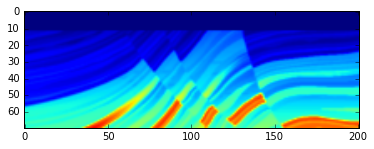

In [2]:
model = get_true_model()

# Plot true velocity
fig1 = plt.figure()
l = plt.imshow(np.transpose(model.vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

## Create "initial guess" by smoothening the synthetic velocity model.

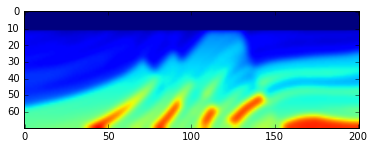

In [3]:
model0 = get_initial_model()

# Plot smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(model0.vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

## Example of a shot record

In [10]:
%load_ext snakeviz

GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/2e8ce9ac7f0c8287108c316ac4e5a0de4bfdc3f7.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/1b0f5bb446216283f72fd9b80f90c428e73d2b7c.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/bd4808507c7fda29221449f79f0c7ac3ba19da74.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/caf66eea441b961637e741311771d4cb507abbb3.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/80134227d3edde2dd4f3b4ff5d21b9bab4e46968.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/00b31f2b45a1db3c3ae458183f7a0cd5d23c42e5.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/b5a335e26cb25c7f1731ab702adacebd8dcc13fb.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/8fc7c8c68131828673c3d

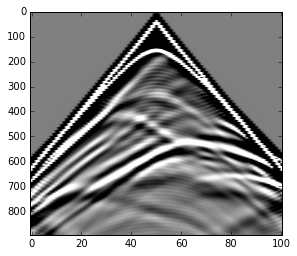

 
*** Profile stats marshalled to file u'/var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/tmp8J4Jll'. 


In [11]:
%%snakeviz
data, rec = get_shot(50)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model0, data, t_order=2, s_order=10)

# Execute acoustic forward model
rec0, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

# Show the shot record at the receivers
fig3 = plt.figure()
l = plt.imshow(rec0, vmin=-.1, vmax=.1, aspect=.1, cmap=cm.gray)
plt.show()

## RTM loop

In [ ]:
%%snakeviz

def grad_shot(i):
    import sys
    sys.path.append('/Users/ggorman/projects/opesci/devito/examples/acoustic/')

    import demo_toolkit
    model0 = demo_toolkit.get_initial_model()
    data, rec = demo_toolkit.get_shot(i)

    Acoustic0 = demo_toolkit.Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)

    # Return gradient
    return Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

grad = None
grads = v.map(grad_shot, range(problem_spec['nsrc']))

for igrad in grads:
    if grad is None:
        grad = np.copy(igrad)
    else:
        grad = grad + igrad
fig4 = plt.figure()
l = plt.imshow(np.diff(np.diff(np.transpose(grad[40:-40,40:-40]),1,0),1), 
               vmin=-100, vmax=100, aspect=1, cmap=cm.gray)
plt.show()

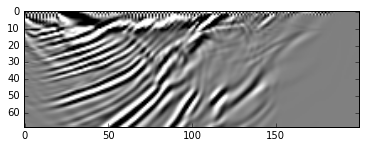

In [6]:
# RTM result
fig4 = plt.figure()
l = plt.imshow(np.diff(np.diff(np.transpose(grad[40:-40,40:-40]),1,0),1), 
               vmin=-100, vmax=100, aspect=1, cmap=cm.gray)
plt.show()
# Looks ok will rerun with better model